# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

In [5]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
state_size

33

In [7]:
# creating the configuration dictionary
myConfig = {};
myConfig["buffer_size"] = int(1e5)  # replay buffer size
myConfig["batch_size"] = 256        # minibatch size
myConfig["gamma"] = 0.95            # discount factor
myConfig["tau"] = 5e-2              # for soft update of target parameters
myConfig["lr_actor"] = 1e-4         # learning rate of the actor 
myConfig["lr_critic"] = 1e-4        # learning rate of the critic
myConfig["weight_decay"] = 0        # L2 weight decay
myConfig["learn_every"] = 100       # learn after this number of steps
myConfig["learn_times"] = 40        # number of sampling and training per cycle
myConfig["state_size"] = state_size
myConfig["action_size"] = action_size
myConfig["random_seed"] = 10

In [8]:
%pdb off
import torch
#Taken from ddpg-pendulum notebook, just like the agent and model python files.
def ddpg(n_episodes=10000, max_t=20000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            reward = env_info.rewards[0];
            done = env_info.local_done[0];
            next_state = env_info.vector_observations[0];
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
        if np.mean(scores_deque) > 30.0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEnvironment SOLVED, results were saved.');
            break;
            
    return scores

agent = Agent(config=myConfig)
env_info = env.reset(train_mode=True)[brain_name]
scores = ddpg()

Automatic pdb calling has been turned OFF
Episode 1	Score: 0.30	Average Score: 0.30
Episode 2	Score: 0.24	Average Score: 0.27
Episode 3	Score: 0.38	Average Score: 0.31
Episode 4	Score: 1.39	Average Score: 0.58
Episode 5	Score: 1.00	Average Score: 0.66
Episode 6	Score: 1.60	Average Score: 0.82
Episode 7	Score: 1.90	Average Score: 0.97
Episode 8	Score: 2.13	Average Score: 1.12
Episode 9	Score: 0.43	Average Score: 1.04
Episode 10	Score: 0.80	Average Score: 1.02
Episode 11	Score: 1.28	Average Score: 1.04
Episode 12	Score: 1.68	Average Score: 1.09
Episode 13	Score: 2.21	Average Score: 1.18
Episode 14	Score: 0.53	Average Score: 1.13
Episode 15	Score: 1.22	Average Score: 1.14
Episode 16	Score: 2.43	Average Score: 1.22
Episode 17	Score: 0.52	Average Score: 1.18
Episode 18	Score: 1.69	Average Score: 1.21
Episode 19	Score: 1.93	Average Score: 1.25
Episode 20	Score: 0.60	Average Score: 1.21
Episode 21	Score: 2.14	Average Score: 1.26
Episode 22	Score: 4.44	Average Score: 1.40
Episode 23	Score: 2.7

Episode 187	Score: 39.42	Average Score: 18.24
Episode 188	Score: 37.93	Average Score: 18.54
Episode 189	Score: 37.16	Average Score: 18.84
Episode 190	Score: 25.42	Average Score: 19.00
Episode 191	Score: 38.62	Average Score: 19.33
Episode 192	Score: 37.52	Average Score: 19.65
Episode 193	Score: 38.85	Average Score: 19.99
Episode 194	Score: 39.48	Average Score: 20.31
Episode 195	Score: 34.88	Average Score: 20.60
Episode 196	Score: 22.90	Average Score: 20.80
Episode 197	Score: 39.56	Average Score: 21.13
Episode 198	Score: 37.75	Average Score: 21.45
Episode 199	Score: 37.93	Average Score: 21.73
Episode 200	Score: 26.32	Average Score: 21.89
Episode 201	Score: 36.10	Average Score: 22.14
Episode 202	Score: 38.25	Average Score: 22.44
Episode 203	Score: 36.03	Average Score: 22.71
Episode 204	Score: 37.87	Average Score: 23.04
Episode 205	Score: 39.40	Average Score: 23.34
Episode 206	Score: 37.14	Average Score: 23.64
Episode 207	Score: 37.76	Average Score: 23.90
Episode 208	Score: 39.37	Average S

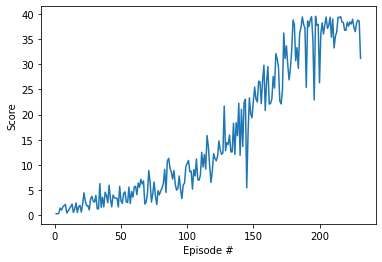

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
env.reset()

{'ReacherBrain': <unityagents.brain.BrainInfo at 0x1f9a27a3128>}